<a href="https://colab.research.google.com/github/vantuan5644/MachineLearningCourse/blob/master/BostonMarathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boston Marathon Dataset

Boston Marathon Dataset is about marathon participants,  the dataset contains the name, age, gender, country, city and state (where available), times at 9 different stages of the race, expected time, finish time and pace, overall place, gender place and division place.


We will use clustering algorithm (k-Means, DBSCAN) to divide the data points into k-clusters with k is determined by our purpose
 - Group by Gender (k = 2)
 - Group by Age group (k = 3)
  - Age from 18 to 25
  - Age from 26 to 40
  - Age from 41 to 70
 - Finishing time

- Time columns:
 - 5K: Time at 5K Mark - string - format: mm
 - 10K: Time at 10K Mark - string - format: mm
 - 15K: Time at 15K Mark - string - format: mm
 - 20K: Time at 20K Mark - string - format: mm
 - Half: Time at Half Marathon Mark - string - format: mm
 - 25K: Time at 25K Mark - string - format: mm
 - 30K: Time at 30K Mark - string - format: mm
 - 35K: Time at 35K Mark - string - format: mm
 - 40K: Time at 40K Mark - string - format: mm
 - Official Time: Athlete's Official Time - string - format: mm

- Pace: Athlete's Pace (avg. time per km)

- Overall: Athlete's position overall

- Division: Athlete's position division (in a specific group)

- Genderdiv: Athlete's gender division (in gender group)




# Import libraries

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [0]:
%matplotlib inline
plt.style.use('seaborn-white')

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')


In [0]:
# CPU info
!cat /proc/cpuinfo

In [0]:
# Test if GPU is working
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Clone the repository

In [0]:
!git clone https://github.com/llimllib/bostonmarathon.git

Cloning into 'bostonmarathon'...
remote: Enumerating objects: 339, done.
remote: Total 339 (delta 0), reused 0 (delta 0), pack-reused 339
Receiving objects: 100% (339/339), 55.57 MiB | 20.11 MiB/s, done.
Resolving deltas: 100% (138/138), done.


# Do data exploration


In [0]:
data = pd.read_csv('/content/bostonmarathon/results/2014/results.csv')

In [0]:
print(data.shape)
data = data.sort_index(axis=1)

(31984, 21)


In [0]:
data.columns

Index(['10k', '20k', '25k', '30k', '35k', '40k', '5k', 'age', 'bib', 'city',
       'country', 'ctz', 'division', 'gender', 'genderdiv', 'half', 'name',
       'official', 'overall', 'pace', 'state'],
      dtype='object')

In [0]:
continuous_cols = ['10k', '20k', '25k', '30k', '35k', '40k', '5k', 
                   'half', 'official', 'pace']

categorical_cols_ordinal = ['age', 'division', 'genderdiv', 'overall']

categorical_cols_n_ordinal = ['bib', 'city', 'country', 'name', 'gender', 'state']

*Remove null values in numeric columns*


In [0]:
data[continuous_cols].dtypes

10k          object
20k          object
25k          object
30k          object
35k          object
40k          object
5k           object
half         object
official    float64
pace        float64
dtype: object

In [0]:
for col in continuous_cols:
  if data[col].dtype == 'object':
    data[col] = data[col].str.replace('-', '0')
    data[col] = data[col].astype(float)

In [0]:
data[continuous_cols] = data[continuous_cols].astype('float')

data[categorical_cols_n_ordinal] = data[categorical_cols_n_ordinal].astype('category')

data[categorical_cols_ordinal] = data[categorical_cols_ordinal].astype('category')

We already knew that **genderdiv** athlete's position in their Gender, how about the **division** column?

In [0]:
division = data[['division', 'city', 'gender', 'age']].sort_values('division')

In [0]:
division[division.duplicated(subset=['division', 'city', 'gender'], keep=False)].sort_values('division')

,division,city,gender,age
21784,12,Eugene,M,73
64,12,Eugene,M,29
21117,15,Spokane,F,67
7203,15,Spokane,F,42
3462,19,Fort Lauderdale,M,52
...,...,...,...,...
396,2569,Seoul,M,40
29888,2600,Reading,M,43
26239,2600,Reading,M,49
30027,2609,Framingham,M,43


I guess that the athlete's divisions is about their perfomance in their city, gender and age.

Check for null values

In [0]:
# Quickly check for null values
tab_info = pd.DataFrame(data.dtypes).T.rename(index={0: 'data_type'})
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0: 'null_values'}))
tab_info = tab_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0] * 100).T.rename(index={0: 'null_values (%)'}))
tab_info

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,ctz,division,gender,genderdiv,half,name,official,overall,pace,state
data_type,float64,float64,float64,float64,float64,float64,float64,category,category,category,category,object,category,category,category,float64,category,float64,category,float64,category
null_values,0,0,0,0,0,0,0,0,0,1,0,30740,0,0,0,0,0,0,0,0,2576
null_values (%),0,0,0,0,0,0,0,0,0,0.00312656,0,96.1106,0,0,0,0,0,0,0,0,8.05403


In [0]:
percentage_nan = data.isnull().sum(axis=0) / data.shape[0] * 100
for col in data.columns:
  if percentage_nan[col] > 50:
    data = data.drop(col, axis=1)

In [0]:
data.corr()['official'].sort_values()

25k         0.774548
5k          0.875720
10k         0.898462
20k         0.922466
half        0.925348
30k         0.959883
40k         0.962319
35k         0.975911
pace        0.999897
official    1.000000
Name: official, dtype: float64

## Perfomance within groups: Gender, Age & Pace

### Gender Perfomance

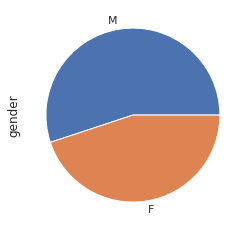

In [0]:
data['gender'].value_counts().plot(kind='pie')

The male athletes tend to be younger (under 40) and vice versa

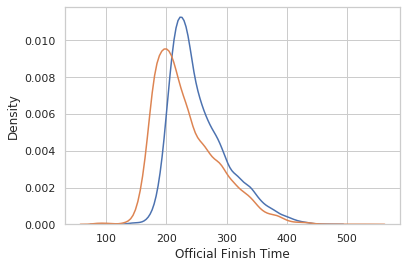

In [0]:
target_0 = data.loc[data['gender'] == 'F']
target_1 = data.loc[data['gender'] == 'M']

sns.distplot(target_0[['official']], hist=False, rug=False)
sns.distplot(target_1[['official']], hist=False, rug=False)
plt.xlabel('Official Finish Time')
plt.ylabel('Density')
plt.show()
del target_0, target_1


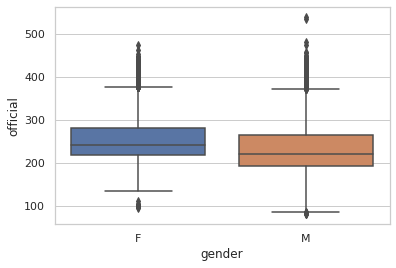

In [0]:
sns.set(style='whitegrid')
sns.boxplot(x='gender', y='official', data=data)

The male athletes have avg. finish time lower than the females. The top finishers are male but there are much more men that need lots of time to make it to the end

### Finishers by Age and Gender

In [0]:
boston = data.copy()
bins = [18, 25, 40, 70]
boston['age_range'] = pd.cut(boston['age'], bins, labels=["18-25", "26-40", "41-70"])


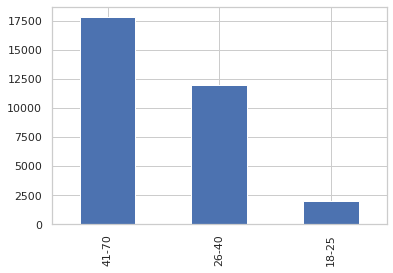

In [0]:
boston['age_range'].value_counts().plot(kind='bar')

Plot the gender ratio within age groups

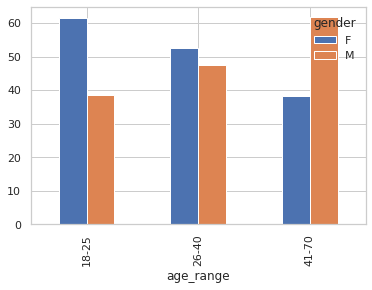

In [0]:
boston_1 = pd.crosstab(boston['age_range'], boston['gender']).apply(lambda r: (r/r.sum()) * 100 , axis=1)
boston_1.plot(kind='bar')
del boston_1

In [0]:
boston_2 = pd.DataFrame(boston.groupby(['age_range', 'gender'])['official'].mean())
boston_2 = boston_2.reset_index(level=0)
boston_2 = boston_2.reset_index()

In [0]:
boston_2

,gender,age_range,official
0,F,18-25,252.599154
1,M,18-25,220.004531
2,F,26-40,249.594463
3,M,26-40,221.594982
4,F,41-70,259.894654
5,M,41-70,239.140229


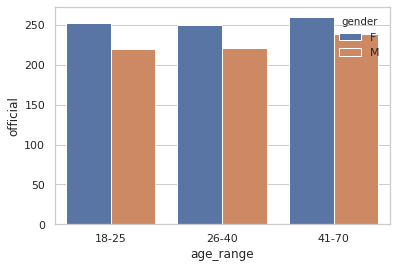

In [0]:
sns.barplot(x='age_range', hue='gender', y='official', data=boston_2)
del boston_2

The avg. finish time difference based on age is not significant

In [0]:
boston_3 = data.groupby(['gender', 'age'])['official'].mean()

In [0]:
boston_3 = boston_3.reset_index(level=0)
boston_3 = boston_3.reset_index()

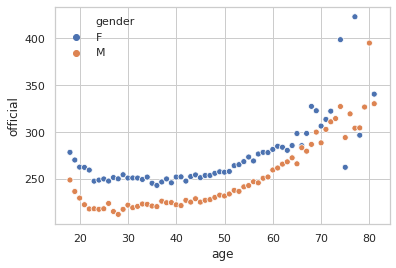

In [0]:
sns.scatterplot(x='age', y='official', hue='gender', data=boston_3)

We can see that avg. finish time of male is better than female if they are lower than 70 years old. There are some outliers (or some extraordinaries old participants that have special result in their age)

## Split
In running, a **negative split** is a racing strategy that involves completing the second half faster than the first half. In contrast, **positive split** means running the second half slower than the first half. Even splits are where the thow halves of the race are run in the same amount of time.

In [0]:
boston_split = data.copy()
boston_split['second_half'] = boston['official'] - boston['half'] 
boston_split['positive'] = boston_split['half'] - boston_split['second_half']
boston_split['positive'] = boston_split['positive'].apply(lambda x: True if x < 0 else False)

In [0]:
boston_split_1 = pd.crosstab(boston_split['positive'], boston_split['gender'])
boston_split_1

gender,F,M
positive,,
False,332,473
True,14035,17144


Majority of the runners ran a positive split. They ran second half slower than the first half, but not by much. There are a very small percent of runners ran a negative split.



In [0]:
boston_split['positive'] = boston_split['half'] - boston_split['second_half']


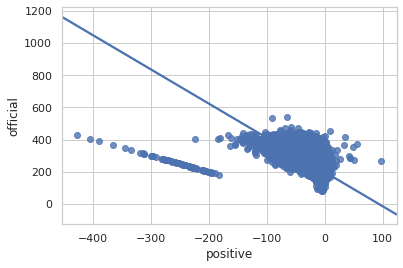

In [0]:
sns.regplot(x="positive", y="official", robust=True, data=boston_split, ci=None)

The best athletes do all have **negative** strategy. In other way, they run the first half faster than the second one.

## Whats winners do

We will take the top-10 in overall result to see what they did in each 5kms

In [0]:
top_10 = data.sort_values('overall').reset_index().iloc[:10]


In [0]:
top_10 = top_10[['5k', '10k', '20k', '25k', '30k', '35k', '40k', 'official']]


In [474]:
top_10

,5k,10k,20k,25k,30k,35k,40k,official
0,7.75,16.62,36.10,45.80,56.45,67.42,76.10,80.60
1,15.15,30.48,61.08,76.00,91.17,106.62,121.82,128.62
2,8.02,17.12,36.58,46.37,57.03,67.83,76.72,81.23
3,15.18,30.52,61.63,76.97,92.52,107.47,121.95,128.80
4,8.00,17.12,36.60,46.37,57.03,67.83,76.70,81.23
5,15.18,30.50,61.63,76.95,92.52,107.47,122.22,128.83
6,15.40,30.82,61.62,76.85,92.50,108.00,122.97,129.62
7,8.38,17.65,37.65,47.67,58.60,70.23,79.83,84.65
8,8.02,17.13,36.98,47.45,58.73,70.60,79.92,84.70
9,15.17,30.48,61.62,76.95,92.52,107.47,122.80,129.83


In [475]:
top_10['5k'] = 5 / top_10['5k']
top_10['10k'] = 15 / top_10['5k']
top_10['20k'] = 20 / top_10['5k']
top_10['25k'] = 25 / top_10['25k']
top_10['30k'] = 30 / top_10['30k']
top_10['35k'] = 35 / top_10['35k']
top_10['40k'] = 40 / top_10['40k']
top_10['official'] = 42.2 / top_10['official']

top_10

,5k,10k,20k,25k,30k,35k,40k,official
0,0.645161,23.25,31.00,0.545852,0.531444,0.519134,0.525624,0.523573
1,0.330033,45.45,60.60,0.328947,0.329056,0.328269,0.328353,0.328098
2,0.623441,24.06,32.08,0.539142,0.526039,0.515996,0.521376,0.519512
3,0.329381,45.54,60.72,0.324802,0.324254,0.325672,0.328003,0.327640
4,0.625000,24.00,32.00,0.539142,0.526039,0.515996,0.521512,0.519512
5,0.329381,45.54,60.72,0.324886,0.324254,0.325672,0.327279,0.327563
6,0.324675,46.20,61.60,0.325309,0.324324,0.324074,0.325283,0.325567
7,0.596659,25.14,33.52,0.524439,0.511945,0.498363,0.501065,0.498523
8,0.623441,24.06,32.08,0.526870,0.510812,0.495751,0.500501,0.498229
9,0.329598,45.51,60.68,0.324886,0.324254,0.325672,0.325733,0.325040


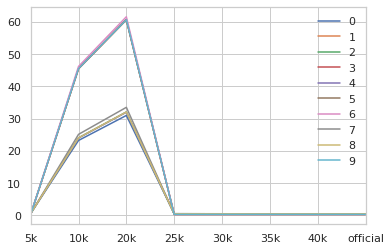

In [476]:
top_10.T.plot(kind='line')

There are 2 main speed strategy of top-10-athletes:
- Run fast in first 5kms, speed up in next 5kms, slow down until got 25kms, and maintain that speed
- Same speed after 25k with group (1) but in the first 25ks they just run with half of speed


# K-Means Clustering

In [0]:
from sklearn.cluster import KMeans

In [0]:
# # Label encoding object columns 
# mappings = []

# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()

# for i, col in enumerate(data):
#     if data[col].dtype == 'object':
#         data[col] = label_encoder.fit_transform(np.array(data[col].astype(str)).reshape((-1,)))
#         mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [0]:
data[categorical_cols_n_ordinal]

,bib,city,country,name,gender,state
0,W1,Fukuoka,JPN,"Yamamoto, Hiroyuki",M,NaN
1,F1,Eldoret,KEN,"Jeptoo, Rita",F,NaN
2,W2,Paarl,RSA,"Van Dyk, Ernst F.",M,NaN
3,F2,Shoa,ETH,"Dibaba, Mare",F,NaN
4,W3,Nogata Fukuoka,JPN,"Hokinoue, Kota",M,NaN
...,...,...,...,...,...,...
31979,35908,Larkspur,USA,"Anderson, Steve K.",M,CA
31980,35909,Norwell,USA,"McCarthy, Michael P.",M,MA
31981,35910,West Simsbury,USA,"Brimmer, Delia C.",F,CT
31982,35911,North Andover,USA,"Morganthal, Amy",F,MA


In [0]:
numeric_data = boston[continuous_cols + ['age_range']]
numeric_data['male'] = data['gender'].apply(lambda x: 1 if x=='M' else 0)

In [0]:
numeric_data = pd.get_dummies(numeric_data, prefix=['age_range'], columns=['age_range'],
                              drop_first=True)

In [0]:
numeric_data

,10k,20k,25k,30k,35k,40k,5k,half,official,pace,male,age_range_26-40,age_range_41-70
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,39.72,85.25,3.27,1,0,1
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,69.47,138.95,5.30,0,1,0
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,38.03,80.60,3.08,1,0,1
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,69.47,140.58,5.37,0,0,0
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,38.60,81.23,3.10,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31979,50.72,99.55,124.02,148.65,174.90,200.22,26.13,104.78,211.75,8.08,1,1,0
31980,61.28,128.37,165.02,203.43,244.70,285.47,31.07,135.85,302.52,11.55,1,1,0
31981,59.00,123.33,157.02,192.65,229.62,266.30,28.18,130.57,282.00,10.77,0,0,0
31982,63.75,129.90,167.82,207.52,247.18,285.87,30.98,137.03,302.73,11.55,0,1,0


In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

X = min_max_scaler.fit_transform(numeric_data)


### Elbow Curve

In [0]:
# Elbow Method to determine optimal k-value
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

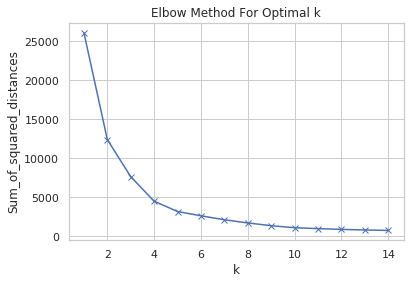

In [0]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Above is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

Thus the optimal **k** values is in range **[6, 15]**

### Silhouette Score Visualization

- Firstly, The mean value should be as close to 1 as possible
- Secondly, The plot of each cluster should be above the mean value as much as possible. Any plot region below the mean value is not desirable.
- Lastly, the width of the plot should be as uniform as possible.

For n_clusters = 2 The average silhouette_score is : 0.518356753300694
For n_clusters = 3 The average silhouette_score is : 0.5747573168767691
For n_clusters = 4 The average silhouette_score is : 0.6443321082457568
For n_clusters = 5 The average silhouette_score is : 0.6927972981274191
For n_clusters = 6 The average silhouette_score is : 0.7131287916410278
For n_clusters = 7 The average silhouette_score is : 0.6675474478877905
For n_clusters = 8 The average silhouette_score is : 0.6635427206210531
For n_clusters = 9 The average silhouette_score is : 0.651469822170418
For n_clusters = 10 The average silhouette_score is : 0.6224965431912125
For n_clusters = 11 The average silhouette_score is : 0.5928649441516795
For n_clusters = 12 The average silhouette_score is : 0.5956065011172301
For n_clusters = 13 The average silhouette_score is : 0.5935403111760102
For n_clusters = 14 The average silhouette_score is : 0.5769724212745199


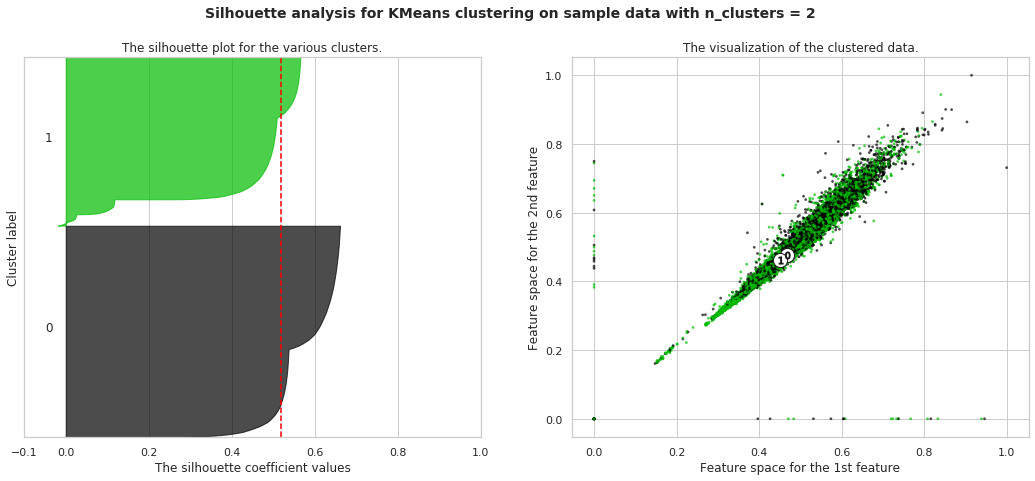

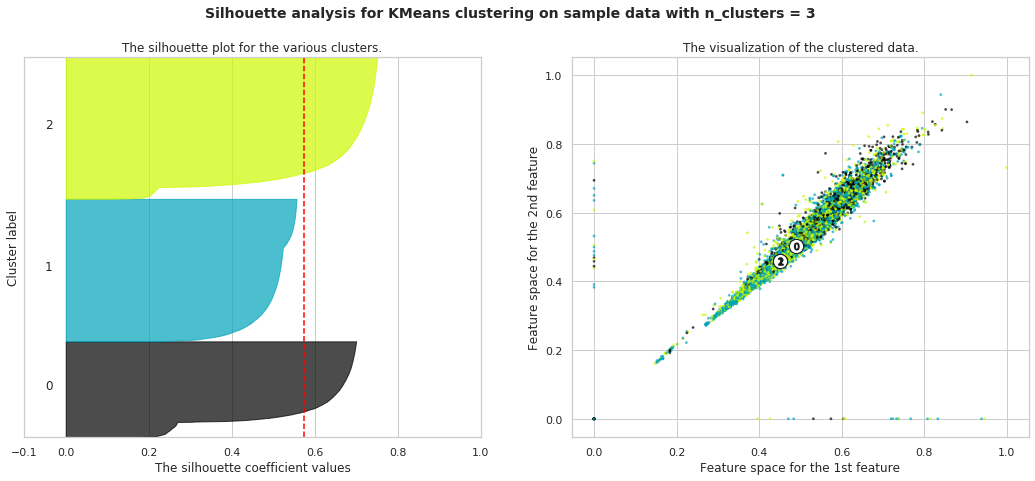

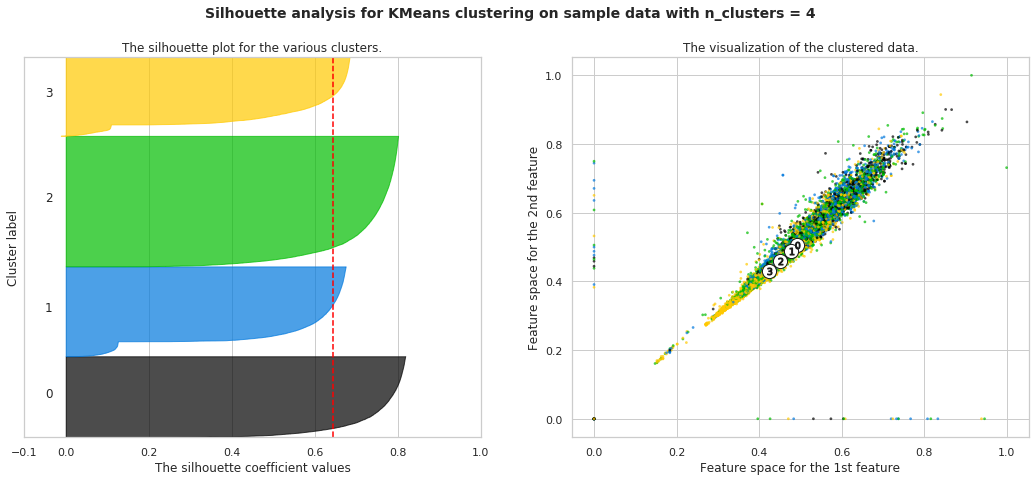

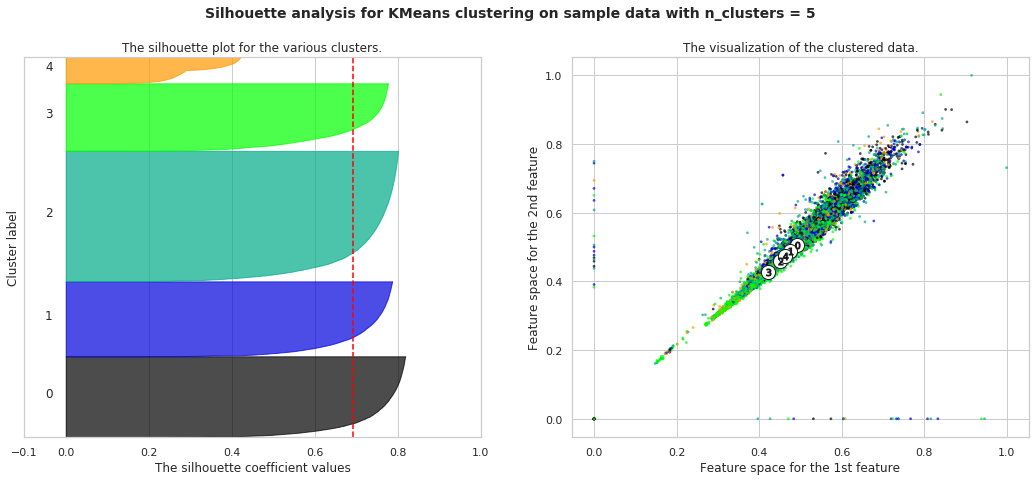

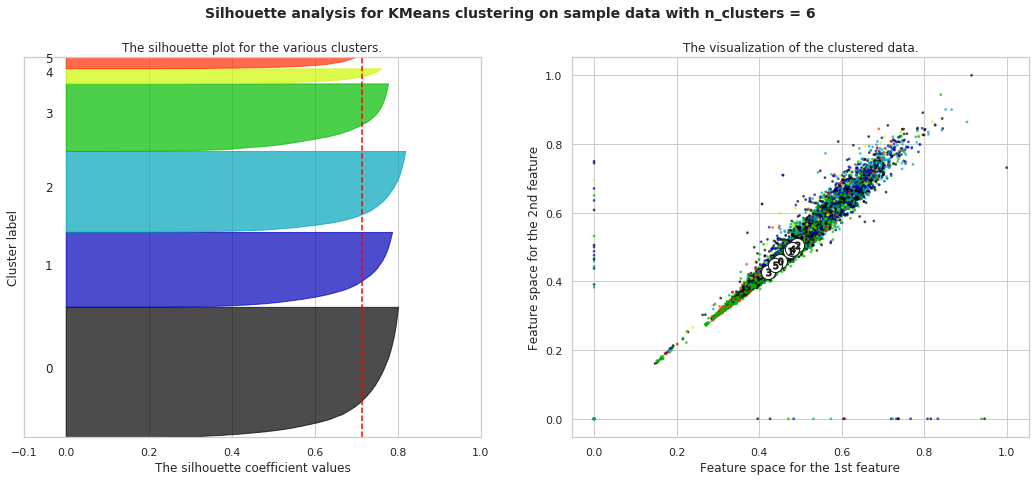

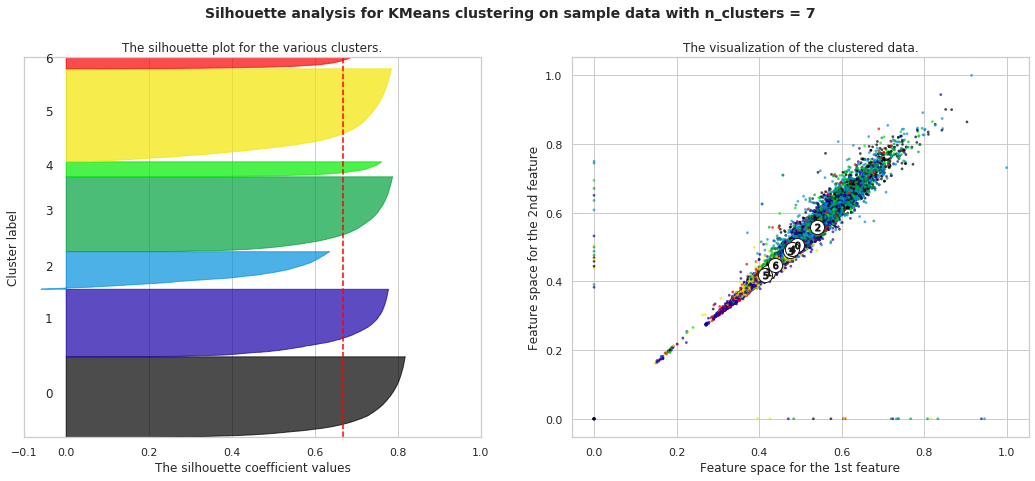

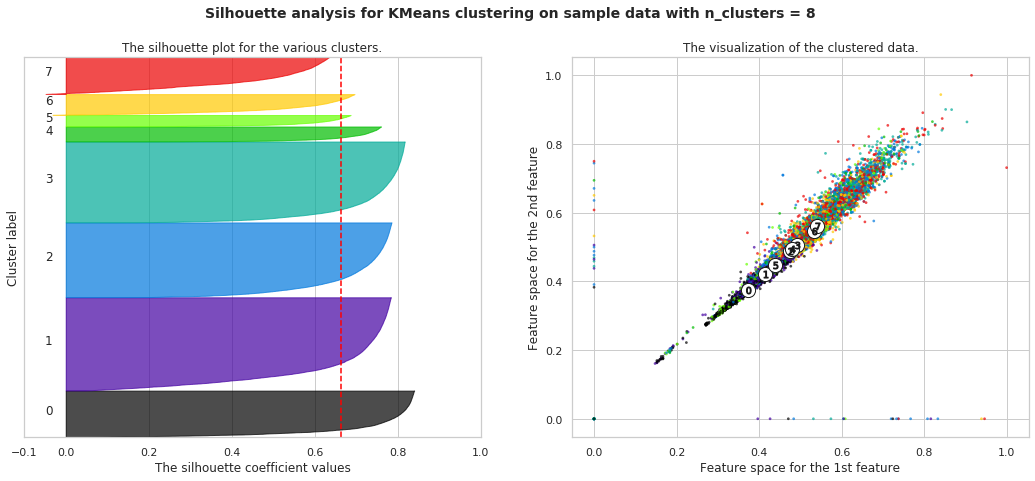

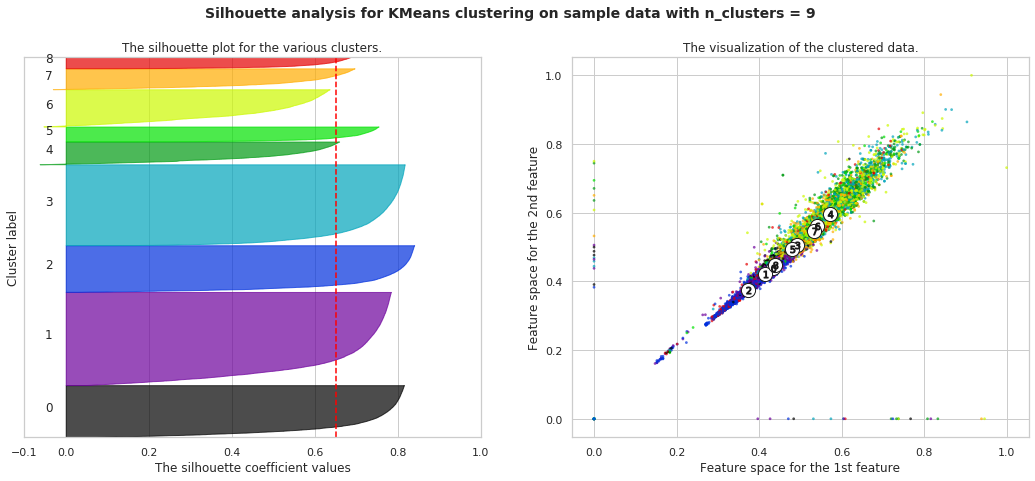

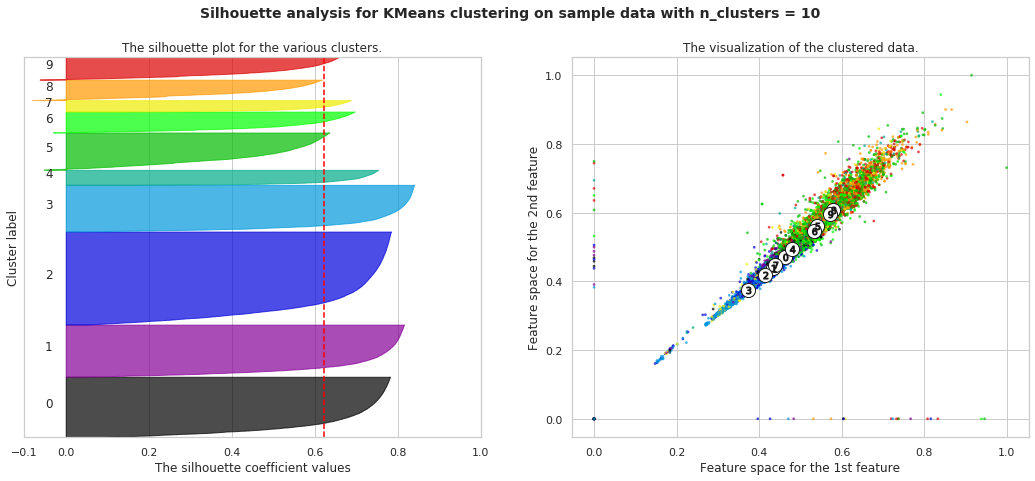

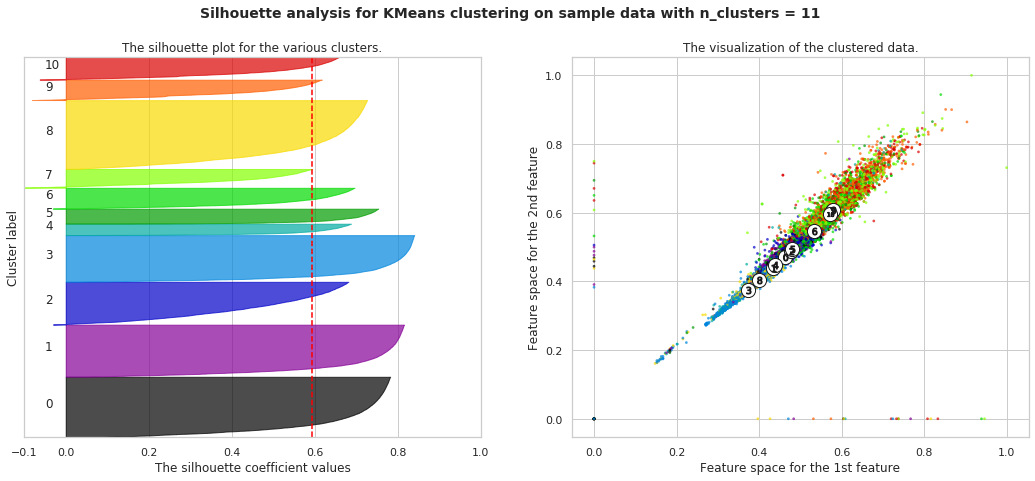

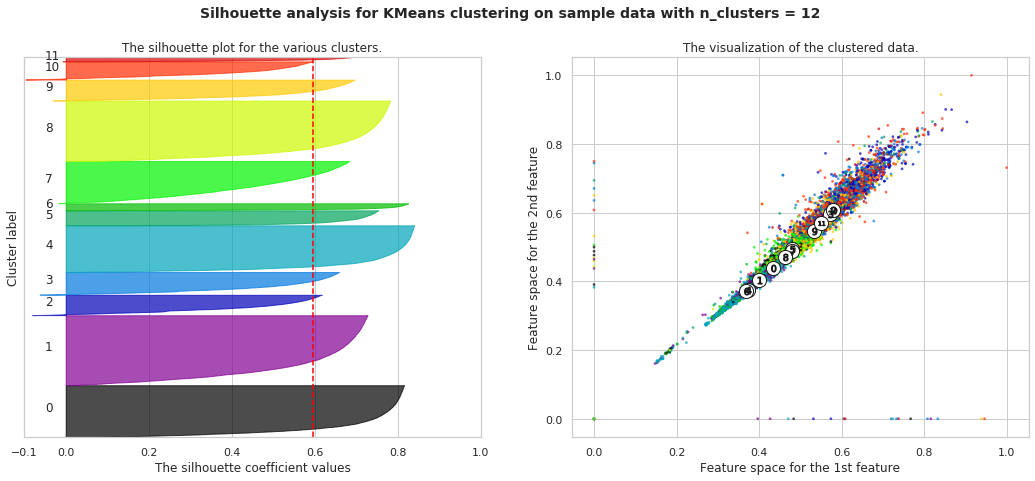

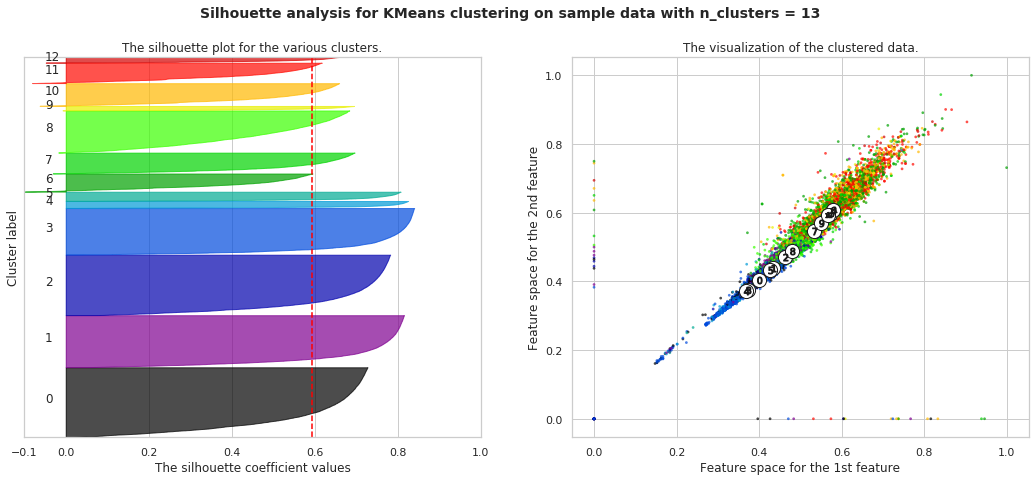

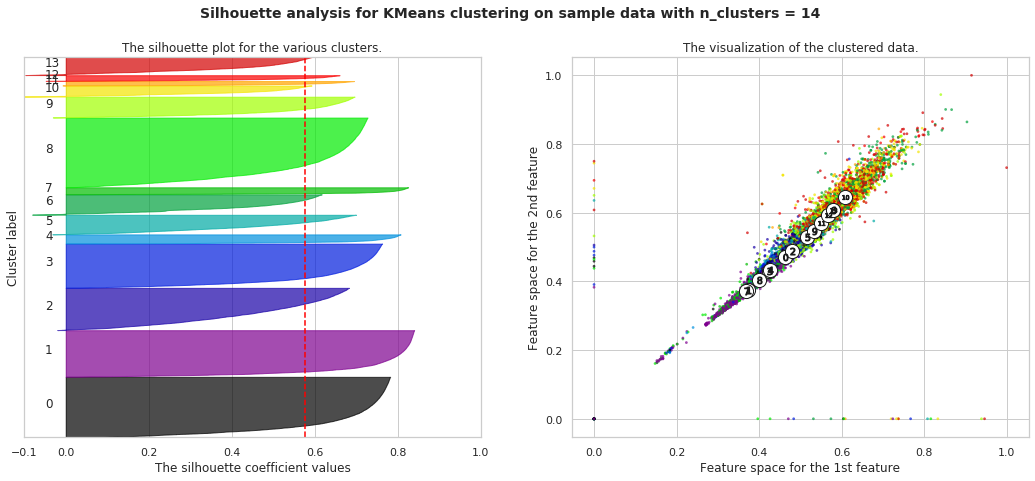

In [359]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm


range_n_clusters = range(2, 15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Use TSNE for visualizing

In [0]:
from sklearn.manifold import TSNE

In [0]:
tsne_2d = TSNE(n_components=2, perplexity=50)

In [0]:
# TCs_2d = pd.DataFrame(tsne_2d.fit_transform(np.delete(X, 12, 1)))
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(X))

In [0]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=1109)
pred_y = kmeans.fit_predict(X)

In [0]:
tsne_result = TCs_2d.copy()
tsne_result['group'] = kmeans.fit_predict(X)

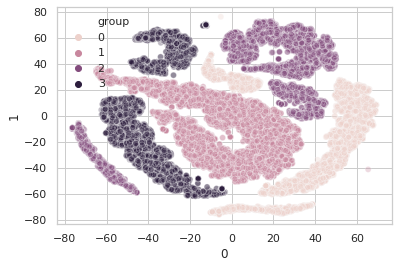

In [365]:
sns.scatterplot(
    x=tsne_result[0], y=tsne_result[1],
    hue="group",
    data=tsne_result,
    legend="full",
    alpha=0.3
)

# Inspect cluster's perfomance metrics
Age_range, Official, Gender

In [0]:
k_means_result = boston.copy()
k_means_result['pred_y'] = pred_y

In [0]:
# k_means_result['age_range_18-25'] = data['age'].apply(lambda x: 1 if 18 <= x <= 25 else 0)

In [404]:
# k_means_result = k_means_result.astype(float)
# k_means_result['female'] = k_means_result['male'].apply(lambda x: 0 if x==1 else 1)
k_means_result.head()

,10k,20k,25k,30k,35k,40k,5k,age,bib,city,country,division,gender,genderdiv,half,name,official,overall,pace,state,age_range,pred_y
0,17.37,37.65,47.67,59.18,71.40,80.43,8.02,47,W1,Fukuoka,JPN,8,M,8,39.72,"Yamamoto, Hiroyuki",85.25,8,3.27,NaN,41-70,1
1,32.58,65.83,82.43,99.33,116.37,132.10,16.22,33,F1,Eldoret,KEN,1,F,1,69.47,"Jeptoo, Rita",138.95,21,5.30,NaN,26-40,2
2,16.62,36.10,45.80,56.45,67.42,76.10,7.75,41,W2,Paarl,RSA,1,M,1,38.03,"Van Dyk, Ernst F.",80.60,1,3.08,NaN,41-70,1
3,32.57,65.83,82.43,99.33,116.37,132.95,16.20,24,F2,Shoa,ETH,3,F,3,69.47,"Dibaba, Mare",140.58,27,5.37,NaN,18-25,2
4,17.12,36.58,46.37,57.03,67.83,76.72,8.02,40,W3,Nogata Fukuoka,JPN,2,M,2,38.60,"Hokinoue, Kota",81.23,2,3.10,NaN,26-40,0


In [0]:
groups_perfomance['official'] = k_means_result.groupby('pred_y').agg({'official': np.mean})
groups_perfomance['pace'] = k_means_result.groupby('pred_y').agg({'pace': np.mean})

In [0]:
groups_perfomance = k_means_result.groupby('pred_y').agg({
                                                          # 'official': np.mean,
                                                          # 'pace': np.mean,
                                                          'gender': pd.Series.value_counts,
                                                          'age_range': pd.Series.value_counts
                                                          }).unstack()
groups_perfomance = groups_perfomance.dropna(axis=1)

## Perfomance of the clusters

In [426]:
groups_perfomance

gender          age_range                     official      pace
             F        M     18-25   26-40    41-70                      
pred_y                                                                  
0          0.0   6638.0     768.0  5682.0      0.0  223.755818  8.541613
1          0.0  10979.0       0.0     0.0  10979.0  239.140229  9.128422
2       7555.0      0.0    1229.0  6300.0      0.0  250.272936  9.553062
3       6812.0      0.0       0.0     0.0   6812.0  259.894654  9.920595

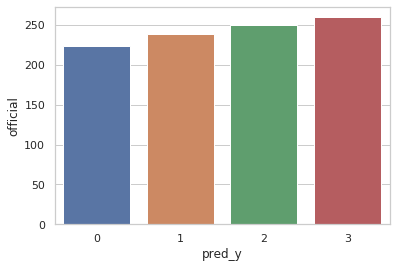

In [428]:
sns.barplot(x='pred_y', y='official', data=groups_perfomance.reset_index())

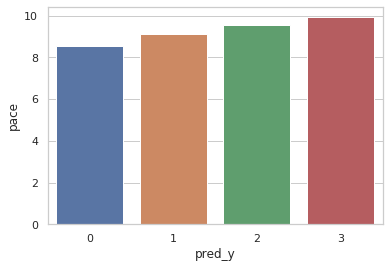

In [429]:
sns.barplot(x='pred_y', y='pace', data=groups_perfomance.reset_index())

The perfomance metrics (avg. finish time and avg. pace is no significantly different between the clusters). The differences come from the categorical features (gender and age group)

In [432]:
groups_perfomance

gender          age_range                     official      pace
             F        M     18-25   26-40    41-70                      
pred_y                                                                  
0          0.0   6638.0     768.0  5682.0      0.0  223.755818  8.541613
1          0.0  10979.0       0.0     0.0  10979.0  239.140229  9.128422
2       7555.0      0.0    1229.0  6300.0      0.0  250.272936  9.553062
3       6812.0      0.0       0.0     0.0   6812.0  259.894654  9.920595

##Age ranges inside Clusters

In [439]:
pd.crosstab(k_means_result['age_range'], k_means_result['pred_y']).apply(lambda r: (r/r.sum()) * 100 , axis=1)

pred_y,0,1,2,3
age_range,,,,
18-25,38.457687,0.000000,61.542313,0.000000
26-40,47.421132,0.000000,52.578868,0.000000
41-70,0.000000,61.710977,0.000000,38.289023


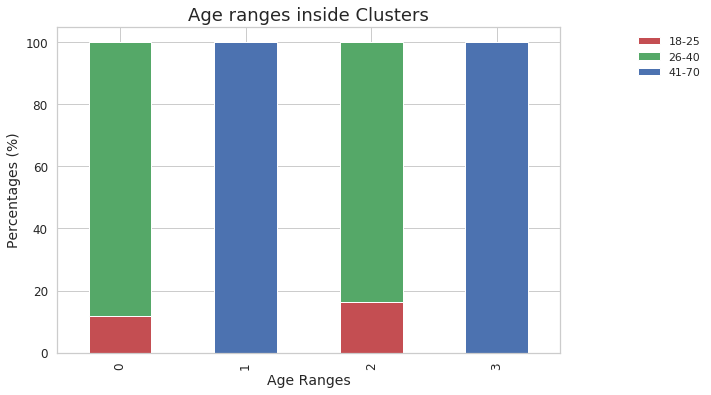

In [443]:
Boston_2 = pd.crosstab(k_means_result['pred_y'], k_means_result['age_range']).apply(lambda r: (r/r.sum()) * 100 , axis=1)

ax1 = Boston_2.plot(kind = "bar", stacked = True, color = ['r', 'g', 'b'], figsize=(9,6),
                      fontsize=12, position=0.5)
ax1.get_legend_handles_labels
ax1.legend(bbox_to_anchor = (1.3, 1))
ax1.set_xlabel('Age Ranges', fontdict={'size':14})
ax1.set_ylabel('Percentages (%)', fontdict={'size':14})
ax1.set_title('Age ranges inside Clusters', fontsize=18)
plt.show()

## Gender inside Clusters

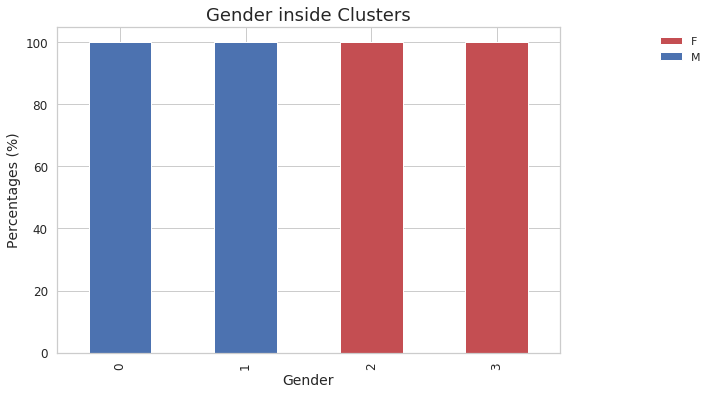

In [444]:
Boston_2 = pd.crosstab(k_means_result['pred_y'], k_means_result['gender']).apply(lambda r: (r/r.sum()) * 100 , axis=1)

ax1 = Boston_2.plot(kind = "bar", stacked = True, color = ['r', 'b'], figsize=(9,6),
                      fontsize=12, position=0.5)
ax1.get_legend_handles_labels
ax1.legend(bbox_to_anchor = (1.3, 1))
ax1.set_xlabel('Gender', fontdict={'size':14})
ax1.set_ylabel('Percentages (%)', fontdict={'size':14})
ax1.set_title('Gender inside Clusters', fontsize=18)
plt.show()